 

# 1.   Preprocessing






  ## 1.1.   Importing Libraries

In [0]:
import cv2
import os
import matplotlib.pyplot  as plt
import numpy              as np
import tensorflow         as tf
import pandas             as pd
from sklearn              import metrics
from sklearn.metrics      import accuracy_score
from skimage              import feature
from tensorflow           import keras

%matplotlib inline

## 1.2.   Mounting Google Drive


In [42]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [43]:
cd /content/gdrive/My\ Drive/a1

/content/gdrive/My Drive/a1


In [44]:
ls

13326487_Krut_A1_ANN.ipynb  t10k-images-idx3-ubyte.gz
13326487_Krut_A1.ipynb      t10k-labels-idx1-ubyte.gz
13326487_Krut_A1_KNN.ipynb  train-images-idx3-ubyte.gz
13326487_Krut_A1_SVM.ipynb  train-labels-idx1-ubyte.gz
DNN_A1.ipynb




## 1.3.   Dataset Preparation




In [0]:
#defining the loading function
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

In [0]:
#Importing data into variables
x_train, y_train = load_mnist('/content/gdrive/My Drive/a1', kind='train')
x_test, y_test = load_mnist('/content/gdrive/My Drive/a1', kind='t10k')
# initialize the label names

labelNames = ["0", "1", "2","3", "4", "5", "6", "7", "8", "9"]

In [47]:
#checking Dimentions of x_train
np.shape(x_train)

(60000, 784)

In [0]:
#converting vector data into Pixels
p_x_train = x_train.reshape(-1,28,28)
p_x_test = x_test.reshape(-1,28,28)

In [0]:
#Normalizing Data
n_x_train = x_train / 255
n_x_test = x_test / 255

In [0]:
# Reshaping Normalized data
r_x_train = n_x_train.reshape(-1,28,28)
r_x_test = n_x_test.reshape(-1,28,28)

In [51]:
#checking Dimentions of x_train
np.shape(r_x_train)

(60000, 28, 28)

In [0]:
#Spliting Dataset for ANN in order to get validation image set

r_x_valid_ann = r_x_train[:5000]
r_y_valid_ann = y_train[:5000]

r_x_train_ann = r_x_train[5000:]
r_y_train_ann = y_train[5000:]



## 1.4.   Image Plotting (Visualization)



In [0]:
#storing image from each class
int_labels =np.asarray(labelNames, dtype=np.int)
class_img = []

for i in range(0,10):
  train_list = list(y_train)
  inter = train_list.index(int_labels[i])
  class_img.append(inter)

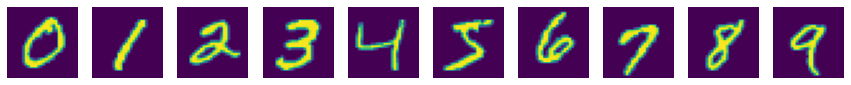

In [54]:
#plotting image of each class
fig = plt.figure(figsize=(15,15))
for i in range (1,11):
  fig.add_subplot(1,10,i)
  plt.imshow(p_x_train[class_img[i-1]])
  plt.axis('off')

plt.show()



# 2.   Feature Extraction




## 2.1.   HoG




In [55]:
# Extracting HoG feature from training dataset
h_x_train = []
h_y_train = []

#Extracting feature from one image at a time
for i in range(len(r_x_train)):
  img = (r_x_train[i])
  hog = feature.hog(img, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
  h_x_train.append(hog)
  h_y_train.append(y_train[i])


print(np.shape(h_x_train))
print(np.shape(h_y_train))

(60000, 36)
(60000,)


In [56]:
# Extracting HoG feature from testing dataset
h_x_test = []
h_y_test = []

for i in range(len(r_x_test)):
  hog_img = (r_x_test[i])
  hog = feature.hog(hog_img, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2), transform_sqrt=True, block_norm="L2-Hys")

  h_x_test.append(hog)
  h_y_test.append(y_test[i])


print(np.shape(h_x_test))
print(np.shape(h_y_test))
print(h_y_test[0])

(10000, 36)
(10000,)
7


In [0]:
#spiliting data for ANN
h_x_valid_ann = h_x_train[:5000]
h_y_valid_ann = h_y_train[:5000]

h_x_train_ann = h_x_train[5000:]
h_y_train_ann = h_y_train[5000:]

In [0]:
#changing the data type of these variables
h_x_train_ann_f = np.asarray(h_x_train_ann, dtype=np.float64)
h_y_train_ann_f = np.asarray(h_y_train_ann, dtype=np.float64)
h_x_valid_ann_f = np.asarray(h_x_valid_ann, dtype=np.float64)
h_y_valid_ann_f = np.asarray(h_y_valid_ann, dtype=np.float64)
h_x_test_f = np.asarray(h_x_test, dtype=np.float64)
h_y_test_f = np.asarray(h_y_test, dtype=np.float64)



## 2.2.   LBP



In [0]:
#defining LBP
class LocalBinaryPatterns:
  #initializing function
	def __init__(self, numPoints, radius):
		self.numPoints = numPoints
		self.radius = radius
 
 #function to extract LBP feature
	def LBPfeatures(self, image, eps=1e-7):
		lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    #converting it to histogram
		(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))
 
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
 
		return hist

In [60]:
# Creating object and extracting LBP feature from training data
lbp_obj = LocalBinaryPatterns(24, 8)
l_x_train = []
l_y_train = []

# Processing one Image at a time
for i in range(len(r_x_train)):
	lbp_img = (r_x_train[i])
	lbp_hist = lbp_obj.LBPfeatures(lbp_img)
	l_x_train.append(lbp_hist)
	l_y_train.append(y_train[i])
 

print(np.shape(l_x_train))
print(np.shape(l_y_train))

(60000, 26)
(60000,)


In [61]:
# Creating object and extracting LBP feature from testing data
lbp_obj = LocalBinaryPatterns(24, 8)
l_x_test = []
l_y_test = []

# Processing one Image at a time
for i in range(len(r_x_test)):
	lbp_img = (r_x_test[i])
	lbp_hist = lbp_obj.LBPfeatures(lbp_img)
	l_x_test.append(lbp_hist)
	l_y_test.append(y_test[i])
 

print(np.shape(l_x_test))
print(np.shape(l_y_test))

(10000, 26)
(10000,)


In [0]:
#spiliting data for ANN
l_x_valid_ann = l_x_train[:5000]
l_y_valid_ann = l_y_train[:5000]

l_x_train_ann = l_x_train[5000:]
l_y_train_ann = l_y_train[5000:]

In [0]:
#changing the data type of these variables
l_x_train_ann_f = np.asarray(l_x_train_ann, dtype=np.float64)
l_y_train_ann_f = np.asarray(l_y_train_ann, dtype=np.float64)
l_x_valid_ann_f = np.asarray(l_x_valid_ann, dtype=np.float64)
l_y_valid_ann_f = np.asarray(l_y_valid_ann, dtype=np.float64)
l_x_test_f = np.asarray(l_x_test, dtype=np.float64)
l_y_test_f = np.asarray(l_y_test, dtype=np.float64)



# 5.   ANN




## 5.1.   Training and evaluating ANN with LBP

In [0]:
#defining model
lbp_ann = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=[26]), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [65]:
#compilation of model and fitting the data
lbp_ann.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

lbp_ann_fit=lbp_ann.fit(l_x_train_ann_f, l_y_train_ann_f, epochs=12, validation_data=(l_x_valid_ann_f, l_y_valid_ann_f))

Epoch 1/12
1719/1719 [==============================] - 6s 4ms/step - loss: 1.8005 - accuracy: 0.3316 - val_loss: 1.6321 - val_accuracy: 0.4132
Epoch 2/12
1719/1719 [==============================] - 7s 4ms/step - loss: 1.5418 - accuracy: 0.4407 - val_loss: 1.4663 - val_accuracy: 0.4550
Epoch 3/12
1719/1719 [==============================] - 6s 4ms/step - loss: 1.4636 - accuracy: 0.4734 - val_loss: 1.4352 - val_accuracy: 0.4734
Epoch 4/12
1719/1719 [==============================] - 6s 3ms/step - loss: 1.4328 - accuracy: 0.4828 - val_loss: 1.3924 - val_accuracy: 0.4866
Epoch 5/12
1719/1719 [==============================] - 6s 3ms/step - loss: 1.4129 - accuracy: 0.4912 - val_loss: 1.3765 - val_accuracy: 0.4916
Epoch 6/12
1719/1719 [==============================] - 6s 4ms/step - loss: 1.4033 - accuracy: 0.4911 - val_loss: 1.3822 - val_accuracy: 0.4926
Epoch 7/12
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3922 - accuracy: 0.4979 - val_loss: 1.3639 - val_accuracy:

In [66]:
lbp_ann.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 26)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               3456      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 173,194
Trainable params: 173,194
Non-trainable params: 0
_________________________________________________________________


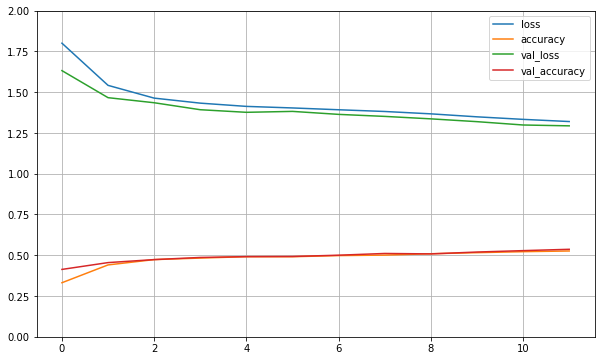

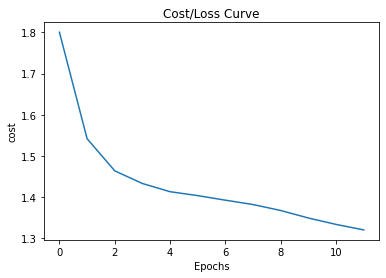

In [94]:
#plotting learning curves
pd.DataFrame(lbp_ann_fit.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-2]
plt.show()

plt.plot(lbp_ann_fit.history['loss'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Cost/Loss Curve")
plt.show()

In [68]:
#evaluating model
lbp_ann.evaluate(l_x_test_f, l_y_test_f)

313/313 [==============================] - 1s 2ms/step - loss: 1.2883 - accuracy: 0.5405


[1.2883352041244507, 0.5404999852180481]

In [0]:
#predicting values
lbp_ann_pred = lbp_ann.predict(l_x_test_f)

In [0]:
#converting predicted results into labels
lbp_ann_final = []

for i in range(len(y_test)):
  x = lbp_ann_pred[i]
  pre = x.argmax(axis=0)
  lbp_ann_final.append(pre)

In [71]:
# plot the confusion matrix
print("Y axis represents the actual label with 0 as lower and 9 as upper")
print("X axis represents the predicted label with 0 as leftmost and 9 as rightmost")
cm  = metrics.confusion_matrix(l_y_test,lbp_ann_final)
print(cm)

Y axis represents the actual label with 0 as lower and 9 as upper
X axis represents the predicted label with 0 as leftmost and 9 as rightmost
[[ 878    0    7    5    5   53    0    7    3   22]
 [   0 1061    2    1    3    2    4   56    5    1]
 [   5    0  477   93   53   57   66  128  127   26]
 [   7    3  142  356   70   90   45  104  123   70]
 [   1    0  102   29  365   16   54   50   66  299]
 [  59    2   85  147   65  178   44  158   58   96]
 [  16    2  160   78   47   54  179   96  157  169]
 [   9   17   55   37   56   33   40  701   29   51]
 [   9    0   36   79   48    8   55   21  632   86]
 [  14    5    9   35  151   29   68   31   89  578]]


In [0]:
# Display the some classification result on test samples
lbp_ann_img = []
lbp_ann_lbl = []

for i in np.random.choice(np.arange(0, len(y_test)), size=(50,)):
  
  image = r_x_test[i]
  prediction = lbp_ann_final[i]
  lbp_ann_img.append(image)
  lbp_ann_lbl.append(prediction)

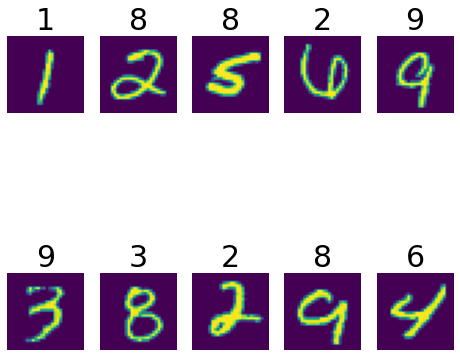

In [73]:
#plotting random predicted outputs
fig = plt.figure(figsize=(8,8))
for i in range (1,11):
  fig.add_subplot(2,5,i)
  plt.title(lbp_ann_lbl[i-1], size= 30)
  plt.imshow(lbp_ann_img[i-1])
  plt.axis('off')

plt.show()

## 5.2.   Training and evaluating ANN with HoG

In [0]:
#defining model
hog_ann = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=[36]), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [75]:
#compilation of model and fitting the data
hog_ann.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

hog_ann_fit=hog_ann.fit(h_x_train_ann_f, h_y_train_ann_f, epochs=12, validation_data=(h_x_valid_ann_f, h_y_valid_ann_f))

Epoch 1/12
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5213 - accuracy: 0.8293 - val_loss: 0.3906 - val_accuracy: 0.8700
Epoch 2/12
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3524 - accuracy: 0.8825 - val_loss: 0.2989 - val_accuracy: 0.9020
Epoch 3/12
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3131 - accuracy: 0.8957 - val_loss: 0.2913 - val_accuracy: 0.9030
Epoch 4/12
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2852 - accuracy: 0.9037 - val_loss: 0.2720 - val_accuracy: 0.9074
Epoch 5/12
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2688 - accuracy: 0.9096 - val_loss: 0.2772 - val_accuracy: 0.9080
Epoch 6/12
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2544 - accuracy: 0.9141 - val_loss: 0.3166 - val_accuracy: 0.8904
Epoch 7/12
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2413 - accuracy: 0.9187 - val_loss: 0.2790 - val_accuracy:

In [76]:
hog_ann.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               4736      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
Total params: 174,474
Trainable params: 174,474
Non-trainable params: 0
_________________________________________________________________


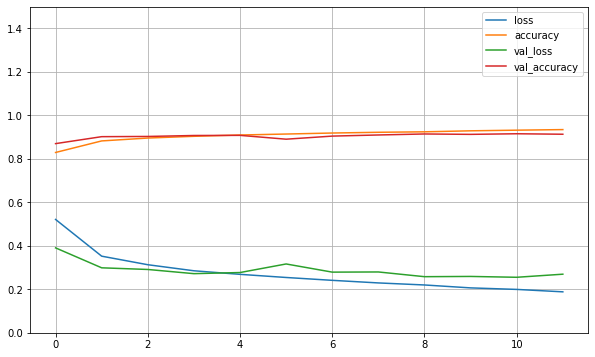

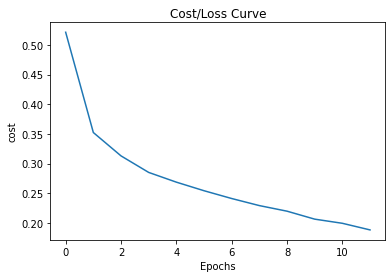

In [77]:
#plotting learning curves
pd.DataFrame(hog_ann_fit.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1.5]
plt.show()

plt.plot(hog_ann_fit.history['loss'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Cost/Loss Curve")
plt.show()

In [78]:
#evaluating model
hog_ann.evaluate(h_x_test_f, h_y_test_f)

313/313 [==============================] - 0s 1ms/step - loss: 0.2816 - accuracy: 0.9122


[0.2816131114959717, 0.9121999740600586]

In [0]:
#predicting values
hog_ann_pred = hog_ann.predict(h_x_test_f)

In [0]:
#converting predicted results into labels
hog_ann_final = []

for i in range(len(y_test)):
  x = hog_ann_pred[i]
  pre = x.argmax(axis=0)
  hog_ann_final.append(pre)

In [81]:
# plot the confusion matrix
print("Y axis represents the actual label with 0 as lower and 9 as upper")
print("X axis represents the predicted label with 0 as leftmost and 9 as rightmost")
cm  = metrics.confusion_matrix(h_y_test, hog_ann_final)
print(cm)

Y axis represents the actual label with 0 as lower and 9 as upper
X axis represents the predicted label with 0 as leftmost and 9 as rightmost
[[ 919    6    4    1    3    4    7    0   32    4]
 [   5 1116    3    1    0    0    4    1    5    0]
 [   8    4  933   33    5    5    1   17   22    4]
 [   1    0   26  918    1   25    0   12   25    2]
 [   2    3    5    1  917    2   31    2   12    7]
 [   4    2    5   30    0  826    6    3   14    2]
 [  24    3    2    0   45    9  855    0   16    4]
 [   9    8   59   31    1    5    0  902    5    8]
 [  21    0    4   27    5   31    9    0  858   19]
 [   9    6    3   14   11   26    1    3   58  878]]


In [0]:
# Display the some classification result on test samples
hog_ann_img = []
hog_ann_lbl = []

for i in np.random.choice(np.arange(0, len(y_test)), size=(50,)):
  
  image = r_x_test[i]
  predict = hog_ann_final[i]
  hog_ann_img.append(image)
  hog_ann_lbl.append(predict)

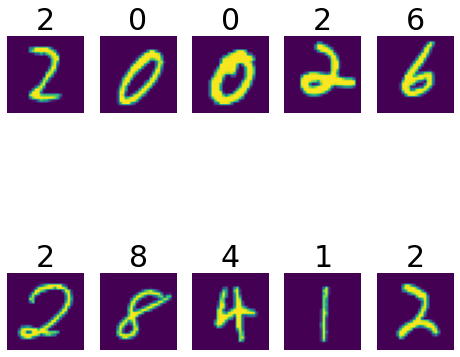

In [83]:
#plotting random predicted outputs
fig = plt.figure(figsize=(8,8))
for i in range (1,11):
  fig.add_subplot(2,5,i)
  plt.title(hog_ann_lbl[i-1], size= 30)
  plt.imshow(hog_ann_img[i-1])
  plt.axis('off')

plt.show()

## 5.3.   Training and evaluating ANN with Raw Data


In [0]:
#defining model
raw_ann = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=[28,28]), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [85]:
#compilation of model and fitting the data
raw_ann.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

raw_ann_fit=raw_ann.fit(r_x_train_ann, r_y_train_ann, epochs=12, validation_data=(r_x_valid_ann, r_y_valid_ann))

Epoch 1/12
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2232 - accuracy: 0.9318 - val_loss: 0.1080 - val_accuracy: 0.9666
Epoch 2/12
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1019 - accuracy: 0.9691 - val_loss: 0.1102 - val_accuracy: 0.9686
Epoch 3/12
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0746 - accuracy: 0.9765 - val_loss: 0.0854 - val_accuracy: 0.9740
Epoch 4/12
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0582 - accuracy: 0.9815 - val_loss: 0.0856 - val_accuracy: 0.9754
Epoch 5/12
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0480 - accuracy: 0.9849 - val_loss: 0.0901 - val_accuracy: 0.9734
Epoch 6/12
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0414 - accuracy: 0.9871 - val_loss: 0.0852 - val_accuracy: 0.9772
Epoch 7/12
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0343 - accuracy: 0.9891 - val_loss: 0.0790 - val_accuracy:

In [86]:
raw_ann.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                5130      
Total params: 270,218
Trainable params: 270,218
Non-trainable params: 0
_________________________________________________________________


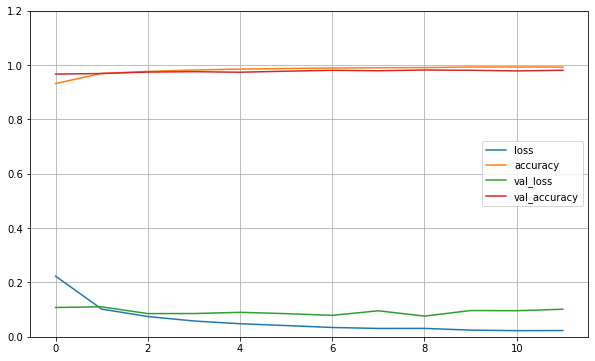

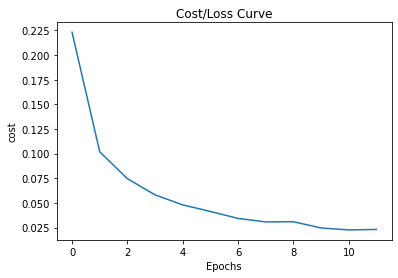

In [87]:
#plotting learning curves
pd.DataFrame(raw_ann_fit.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1.2) # set the vertical range to [0-1.2]
plt.show()

plt.plot(raw_ann_fit.history['loss'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Cost/Loss Curve")
plt.show()

In [88]:
#evaluating model
raw_ann.evaluate(r_x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1114 - accuracy: 0.9791


[0.11140961945056915, 0.9790999889373779]

In [0]:
#making predictions
raw_ann_pred = raw_ann.predict(r_x_test)

In [0]:
#converting predicted results into labels
raw_ann_final = []

for i in range(len(y_test)):
  x = raw_ann_pred[i]
  pre = x.argmax(axis=0)
  raw_ann_final.append(pre)

In [91]:
# plot the confusion matrix
print("Y axis represents the actual label with 0 as lower and 9 as upper")
print("X axis represents the predicted label with 0 as leftmost and 9 as rightmost")
cm  = metrics.confusion_matrix(y_test, raw_ann_final)
print(cm)

Y axis represents the actual label with 0 as lower and 9 as upper
X axis represents the predicted label with 0 as leftmost and 9 as rightmost
[[ 965    1    1    1    1    2    2    3    3    1]
 [   3 1126    0    1    0    0    2    2    1    0]
 [   3    1 1015    2    1    0    1    3    6    0]
 [   1    0    8  989    0    3    0    1    3    5]
 [   1    2    2    0  963    1    5    2    2    4]
 [   1    2    0   16    1  863    5    2    2    0]
 [   2    2    1    1    1    4  944    0    3    0]
 [   0    5   10    1    0    0    0 1009    2    1]
 [   4    0    5    2    3    4    0    4  949    3]
 [   2    4    0    5   14    5    1    7    3  968]]


In [0]:
# Display the some classification result on test samples
raw_ann_img = []
raw_ann_lbl = []

for i in np.random.choice(np.arange(0, len(y_test)), size=(50,)):
  
  image = r_x_test[i]
  predict = raw_ann_final[i]

  raw_ann_img.append(image)
  raw_ann_lbl.append(predict)

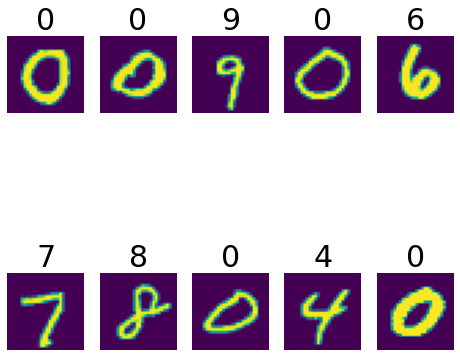

In [93]:
#plotting random predicted outputs
fig = plt.figure(figsize=(8,8))
for i in range (1,11):
  fig.add_subplot(2,5,i)
  plt.title(raw_ann_lbl[i-1], size= 30)
  plt.imshow(raw_ann_img[i-1])
  plt.axis('off')

plt.show()